<a href="https://colab.research.google.com/github/s2cretjuju/first-repository/blob/master/ds6/20251209_%EB%94%A5%EB%9F%AC%EB%8B%9D(6)_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98_%EB%89%B4%EC%8A%A4_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%8B%A4%EC%A4%91_%EB%B6%84%EB%A5%98_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**[프로젝트] 뉴스 카테고리 다중 분류**

#**결론**
accuracy의 감소를 감수하고 macro f1-score를 대폭 개선함으로써, 모델이 불공평한 편향을 버리고 모든 클래스를 공정하게 예측하는 모델로 성공적으로 튜닝

**[SVM 모델 한정]**
* 최적 조건: 단어 개수 5,000개 사용
* 최종 성능
  * accuracy: 0.8045
  * f1-score (macro): 0.6874
  * f1-score (weighted): 0.8060


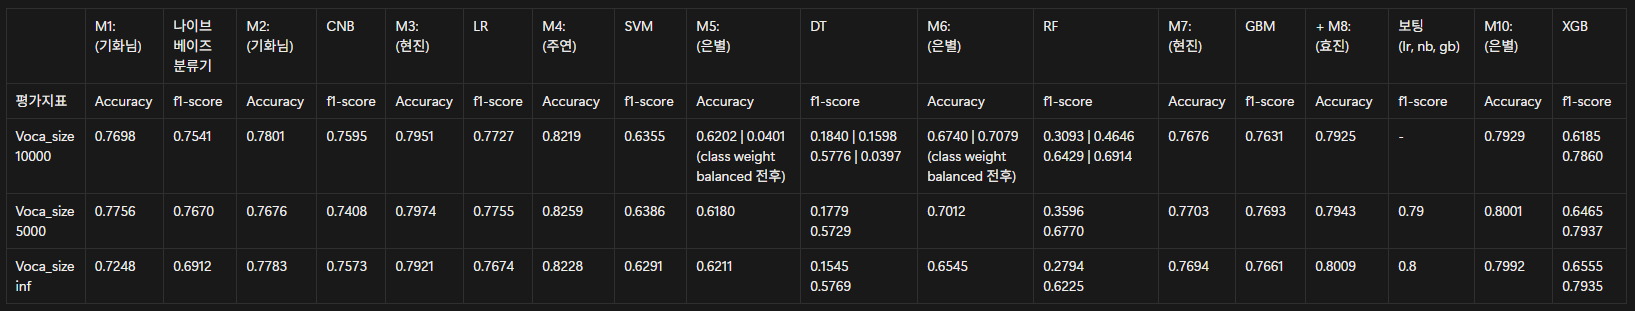

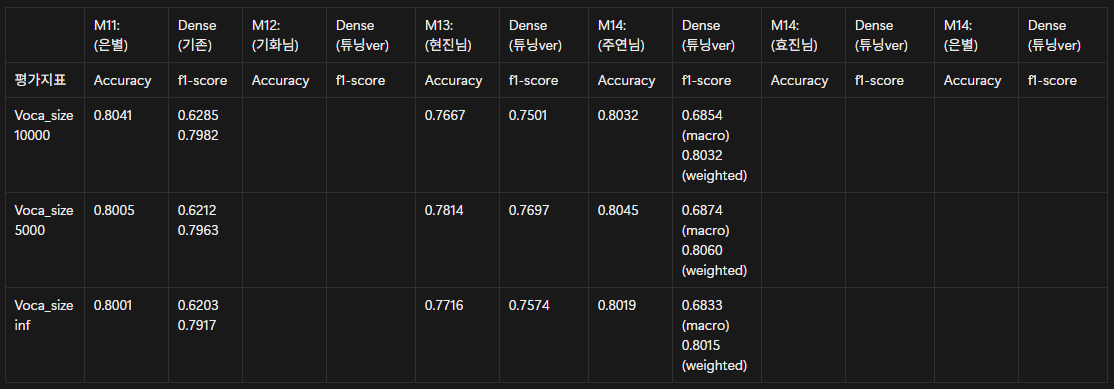

In [1]:
import numpy as np
from tensorflow.keras.datasets import reuters # 로이터 뉴스 데이터셋을 사용합니다.
from sklearn.feature_extraction.text import TfidfVectorizer # 텍스트를 수치 벡터로 변환하는 TF-IDF 방식을 사용합니다.
from sklearn.svm import SVC # SVM(Support Vector Classifier) 모델을 사용합니다.
from sklearn.metrics import accuracy_score, f1_score # 평가 지표인 Accuracy, F1-score를 사용합니다.

# 로이터 데이터셋의 단어 인덱스를 가져옵니다.
word_index = reuters.get_word_index(path="reuters_word_index.json")

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##**2. 데이터 복원 함수 정의**

In [2]:
# 인덱스를 단어로 변환하기 위한 맵 생성 (0, 1, 2는 패딩, 시작, 미등록 단어에 예약되어 있어 +3을 해줍니다.)
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = '<pad>' # 패딩
index_to_word[1] = '<sos>' # 문장 시작
index_to_word[2] = '<unk>' # 미등록 단어

# 정수 시퀀스를 실제 텍스트로 변환하는 함수
def decode_review(numerical_sequence):
    # 각 인덱스를 단어로 변환합니다. (만약 맵에 없는 인덱스라면 '<unk>'로 처리)
    return ' '.join([index_to_word.get(i, '<unk>') for i in numerical_sequence])

##**3. 단어 개수별 SVM 학습 및 평가 실험 함수**

In [3]:
def run_svm_experiment(num_words_limit):
    """
    주어진 최대 단어 개수에 따라 로이터 데이터를 로드하고 SVM을 학습/평가하는 함수

    :param num_words_limit: 사용할 단어의 최대 개수 (None이면 전체 단어 사용)
    """

    # 1. 데이터 로드
    print(f"\n======== 단어 개수: {num_words_limit if num_words_limit is not None else '모든 단어'}개 실험 시작 ========")

    # reuters.load_data를 사용하여 데이터를 로드합니다.
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words_limit,
        test_split=0.2 # 훈련:테스트 비율 8:2
    )

    print(f"훈련 데이터 뉴스 기사 수: {len(x_train)}, 테스트 데이터 뉴스 기사 수: {len(x_test)}")

    # 2. 정수 시퀀스를 텍스트로 변환 (SVM은 텍스트를 직접 받지 못하므로 TF-IDF를 위해 변환합니다.)
    x_train_text = [decode_review(s) for s in x_train]
    x_test_text = [decode_review(s) for s in x_test]

    # 3. TF-IDF 벡터화 (텍스트를 수치 벡터로 변환)
    # TF-IDF는 문서 내에서 단어의 중요도를 계산하여 벡터로 표현하는 방식입니다.
    # SVM과 같은 전통적인 머신러닝 모델에 매우 효과적인 방법입니다.
    tfidf_vectorizer = TfidfVectorizer()

    # 훈련 데이터로 TfidfVectorizer를 '학습'(fit)시키고 '변환'(transform)합니다.
    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_text)

    # 테스트 데이터는 훈련 데이터의 TfidfVectorizer를 사용하여 '변환'(transform)만 합니다. (학습 X)
    x_test_tfidf = tfidf_vectorizer.transform(x_test_text)

    print(f"변환 후 훈련 데이터 Shape: {x_train_tfidf.shape}")
    print(f"변환 후 테스트 데이터 Shape: {x_test_tfidf.shape}")

    # 4. SVM 모델 학습 (SVM Training)
    # SVM은 다중 분류(Multi-class Classification)를 위해 내부적으로 OVR(One-vs-Rest) 방식을 사용합니다.
    # 'C'는 규제 강도로, 클수록 모델이 훈련 데이터에 더 민감하게 학습됩니다.
    # 'kernel'은 비선형 분류를 위해 'linear' 대신 'rbf'를 사용하면 더 좋은 성능을 얻을 수 있습니다.
    svm_model = SVC(kernel='linear', C=1.0, random_state=42)
    print("SVM 모델 학습 중...")
    svm_model.fit(x_train_tfidf, y_train)
    print("SVM 모델 학습 완료!")

    # 5. 예측 및 평가 (Prediction and Evaluation)
    y_pred = svm_model.predict(x_test_tfidf)

    # Accuracy 계산
    acc = accuracy_score(y_test, y_pred)

    # F1-score 계산 (다중 분류에서는 'macro' 또는 'weighted' 평균을 사용해야 합니다.)
    # 'macro' 평균: 각 클래스별 F1-score를 구한 후 단순 평균을 냅니다. 클래스 간 불균형에 덜 민감합니다.
    # 'weighted' 평균: 각 클래스별 F1-score를 샘플 수에 따라 가중 평균합니다.
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ F1-score (macro) : {f1_macro:.4f}")
    print(f"======== 단어 개수: {num_words_limit if num_words_limit is not None else '모든 단어'}개 실험 종료 ========")

    return acc, f1_macro

##**4. 단어 개수별 실험 실행**

In [4]:
# 실험할 단어 개수 리스트
num_words_list = [10000, 5000, None]
results = {}

for n_words in num_words_list:
    acc, f1 = run_svm_experiment(n_words)
    results[n_words] = {'Accuracy': acc, 'F1-score (macro)': f1}

# 최종 결과 정리
print("\n\n==================== 최종 SVM 모델 실험 결과 ====================")
for n_words, metrics in results.items():
    word_count_str = f"{n_words}개" if n_words is not None else "모든 단어"
    print(f"📌 단어 개수: {word_count_str}")
    print(f"   - Accuracy: {metrics['Accuracy']:.4f}")
    print(f"   - F1-score (macro): {metrics['F1-score (macro)']:.4f}")
print("==================================================================")


======== 단어 개수: 10000개 실험 시작 ========
2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 9670)
변환 후 테스트 데이터 Shape: (2246, 9670)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8219
✅ F1-score (macro) : 0.6355
======== 단어 개수: 10000개 실험 종료 ========

======== 단어 개수: 5000개 실험 시작 ========
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 4867)
변환 후 테스트 데이터 Shape: (2246, 4867)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8259
✅ F1-score (macro) : 0.6386
======== 단어 개수: 5000개 실험 종료 ========

======== 단어 개수: 모든 단어개 실험 시작 ========
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 26506)
변환 후 테스트 데이터 Shape: (2246, 26506)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8228
✅ F1-score (macro) : 0.6291
======== 단어 개수: 모든 단어개 실험 종료 ========


==================== 최종 SVM 모델 실험 결과 ====================
📌 단어 개수: 10000개
   - Accuracy: 0.8219
   - F1-score (macro): 0.6355
📌 단어 개수: 5000개
   - Accuracy: 0.82

##**1. 라이브러리 및 데이터 호출**

#**[튜닝 버전]**

##**1. 라이브러리 및 데이터 호출**

In [5]:
import numpy as np
from tensorflow.keras.datasets import reuters # 로이터 뉴스 데이터셋을 사용
from sklearn.feature_extraction.text import TfidfVectorizer # 텍스트를 수치 벡터로 변환하는 TF-IDF 방식을 사용
from sklearn.svm import SVC # SVM(Support Vector Classifier) 모델을 사용
from sklearn.metrics import accuracy_score, f1_score # 평가 지표인 Accuracy, F1-score를 사용합니다.

# 로이터 데이터셋의 단어 인덱스 호출
word_index = reuters.get_word_index(path="reuters_word_index.json")

##**2. 핵심 함수 수정 (run_svm_experiment)**

In [6]:
def run_svm_experiment_with_balance(num_words_limit):
    """
    주어진 최대 단어 개수에 따라 로이터 데이터를 로드하고
    클래스 불균형을 고려한 SVM을 학습/평가하는 함수
    """

    # 1. 데이터 로드 및 TF-IDF 벡터화 (과정 생략)
    # ... (데이터 로드 및 텍스트 변환 과정은 이전과 동일) ...
    print(f"\n======== 단어 개수: {num_words_limit if num_words_limit is not None else '모든 단어'}개 실험 시작 ========")

    # reuters.load_data를 사용하여 데이터를 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(
        num_words=num_words_limit,
        test_split=0.2 # 훈련:테스트 비율 8:2
    )

    print(f"훈련 데이터 뉴스 기사 수: {len(x_train)}, 테스트 데이터 뉴스 기사 수: {len(x_test)}")

    # 2. 정수 시퀀스를 텍스트로 변환 (SVM은 텍스트를 직접 받지 못하므로 TF-IDF를 위해 변환)
    x_train_text = [decode_review(s) for s in x_train]
    x_test_text = [decode_review(s) for s in x_test]

    # 3. TF-IDF 벡터화 (텍스트를 수치 벡터로 변환)
    # TF-IDF는 문서 내에서 단어의 중요도를 계산하여 벡터로 표현하는 방식
    # SVM과 같은 전통적인 머신러닝 모델에 매우 효과적인 방법
    tfidf_vectorizer = TfidfVectorizer()

    # 훈련 데이터로 TfidfVectorizer를 '학습'(fit)시키고 '변환'(transform)
    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_text)

    # 테스트 데이터는 훈련 데이터의 TfidfVectorizer를 사용하여 '변환'(transform)만 진행 (학습 X)
    x_test_tfidf = tfidf_vectorizer.transform(x_test_text)

    print(f"변환 후 훈련 데이터 Shape: {x_train_tfidf.shape}")
    print(f"변환 후 테스트 데이터 Shape: {x_test_tfidf.shape}")

    # 3. SVM 모델 학습 (⭐ 주요 수정 부분 1: class_weight='balanced' 추가)
    print("SVM 모델 학습 중...")

    # class_weight='balanced' 옵션 추가:
    # 이 옵션은 소수 클래스에 더 큰 가중치를 부여하여, 모델이 소수 클래스의 오분류에 대해
    # 더 큰 페널티를 받도록 학습을 유도 (불균형 해소 목적)
    svm_model = SVC(
        kernel='linear',
        C=1.0,
        random_state=42,
        class_weight='balanced' # ⭐ 클래스 불균형 해소 옵션 적용!
    )

    svm_model.fit(x_train_tfidf, y_train)
    print("SVM 모델 학습 완료!")

    # 4. 예측 및 평가 (⭐ 주요 수정 부분 2: F1-score 2가지 계산)
    y_pred = svm_model.predict(x_test_tfidf)

    # Accuracy 계산
    acc = accuracy_score(y_test, y_pred)

    # F1-score (Macro) 계산: 각 클래스를 동등하게 취급 (소수 클래스 성능 반영)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # F1-score (Weighted) 계산: 데이터 개수에 따라 가중치 부여 (실제 데이터 분포 반영)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ F1-score (macro) : {f1_macro:.4f}")
    print(f"✅ F1-score (weighted) : {f1_weighted:.4f}")

    return acc, f1_macro, f1_weighted

##**3. 단어 개수별 실험 실행 및 결과 비교**

In [7]:
# 실험할 단어 개수 리스트
num_words_list = [10000, 5000, None]
results = {}

print("==================== 클래스 가중치 적용 실험 시작 ====================")
for n_words in num_words_list:
    word_count_str = f"{n_words}개" if n_words is not None else "모든 단어"
    print(f"\n[실험] 단어 개수: {word_count_str}")
    acc, f1_macro, f1_weighted = run_svm_experiment_with_balance(n_words)

    results[n_words] = {
        'Accuracy': acc,
        'F1-score (macro)': f1_macro,
        'F1-score (weighted)': f1_weighted
    }

# 최종 결과 정리
print("\n\n==================== 최종 SVM 모델 실험 결과 (Class Weight 적용) ====================")
for n_words, metrics in results.items():
    word_count_str = f"{n_words}개" if n_words is not None else "모든 단어"
    print(f"📌 단어 개수: {word_count_str}")
    print(f"   - Accuracy: {metrics['Accuracy']:.4f}")
    print(f"   - F1-score (macro): {metrics['F1-score (macro)']:.4f} (소수 클래스 성능 확인용)")
    print(f"   - F1-score (weighted): {metrics['F1-score (weighted)']:.4f} (전체 데이터 분포 반영)")
print("==================================================================")

==================== 클래스 가중치 적용 실험 시작 ====================

[실험] 단어 개수: 10000개

======== 단어 개수: 10000개 실험 시작 ========
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 9670)
변환 후 테스트 데이터 Shape: (2246, 9670)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8032
✅ F1-score (macro) : 0.6854
✅ F1-score (weighted) : 0.8032

[실험] 단어 개수: 5000개

======== 단어 개수: 5000개 실험 시작 ========
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 4867)
변환 후 테스트 데이터 Shape: (2246, 4867)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8045
✅ F1-score (macro) : 0.6874
✅ F1-score (weighted) : 0.8060

[실험] 단어 개수: 모든 단어

======== 단어 개수: 모든 단어개 실험 시작 ========
훈련 데이터 뉴스 기사 수: 8982, 테스트 데이터 뉴스 기사 수: 2246
변환 후 훈련 데이터 Shape: (8982, 26506)
변환 후 테스트 데이터 Shape: (2246, 26506)
SVM 모델 학습 중...
SVM 모델 학습 완료!
✅ Accuracy : 0.8019
✅ F1-score (macro) : 0.6833
✅ F1-score (weighted) : 0.8015


==================== 최종 SVM 모델 실험 결과 (Class Weight 적용) ====================
📌 단어 개수: 10000개
   - Accuracy: 0.803

**accuracy가 낮아진 것은 class_weight = 'balanced' 옵션을 사용했을 때 매우 자주, 의도적으로 발생하는 결과**

이것은 모델이 전체 정확도를 희생하는 대신, 더 공정한 분류를 하도록 전략을 바꿨기 때문

#**정확도(accuracy)가 낮아진 이유**

**1. 튜닝 전 모델 (accuracy 중심)**

* 모델의 목표: 전체 샘플 중에서 얼마나 많이 맞혔는가 (accuracy)를 극대화 하는 것

* 클래스 불균형 상황 (예시): 전체 기사 100개 중 '경제' 기사가 90개, '스포츠' 기사가 10개라고 가정

* 모델의 전략: 모델이 모든 기사를 무조건 '경제'라고 예측해도 정확도는 90%
  
  -> 이 때 '스포츠' 기사는 단 하나도 맞히지 못했지만, 90%의 높은 정확도를 유지 가능

**2. 튜닝 후 모델 (class_weight = 'balanced' 적용)**

* 모델의 목표: 소수 클래스('스포츠')를 틀렸을 때 주어지는 패널티를 다수 클래스('경제')를 틀렸을 떄의 패널티보다 훨씬 크게 만듦 (가중치 부여)

* 모델의 전략 변화: 모델은 90%의 정확도를 유지하기 위해 모든 것을 '경제'라고 찍는 위험한 전략을 포기하고, 소수 클래스('스포츠')도 맞히기 위해 노력

  -> 소수 클래스를 맞히는 데 집중하다 보면, 간혹 다수 클래스('경제')를 덜 완벽하게 예측하게 되어 전체 정확도(accuracy)는 90%에서 88 - 87%로 약간 떨어질 수 있음

#**낮은 accuracy를 감수해야 하는 이유**

1. accuracy가 낮아진 것은 다수 클래스에 대한 예측이 약간 희생된 결과

2. macro f1-score가 높아진 것은 소수 클래스에 대한 예측이 크게 개선되었다는 명확한 증거

    => 따라서 낮은 accuracy는 모델이 불공평한 편향을 버리고 공정함을 선택했다는 것으로 해석 가능

    => 다중 분류 및 불균혀 데이터셋에서는 macro f1-score가 accuracy보다 모델의 실제 성능을 더 잘 대변하는 주된 평가 지표가 됨